In [34]:
# -*- coding: utf-8 -*-
"""vrp_dqn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iothquIlGtKKte5KIxO-YCKzXnZGjbK-
"""
# !pip install tsplib95

from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import tsplib95
import networkx as nx
import pickle

import time
import math
import re
import random
import copy

import tensorflow
if tensorflow.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adam
from collections import deque

import io # to save the image
import math

Default GPU Device: /device:GPU:0


In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
# https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
class LearningRateReducerCb(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # old_lr = self.model.optimizer.lr.read_value()
        # new_lr = old_lr * 0.99
        new_lr = 0.1
        # print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [37]:
# 6. Define the movement restriction of the truck.
class Truck:
    def __init__(self, capacity, id, color):
        self.id = id
        self.color = color
        self.path = [] #this has the list of nodes it has visited
        self.max_truck_capacity = copy.deepcopy(capacity) #the max capacity
        self.capacity = copy.deepcopy(capacity)
        #self.visit_depo()
        self.prev_node = None
        self.node = 1 #starts from the depo

    def action(self, choice):
        # the number of choice of actions are the number of nodes-1
        # the choice to be taken depends on the demands - penalty based
        # the choice number is the same as the node number
        # it is not a choice if the demand is 0 - changing this to penalty
        #!! Want the system to learn instead
        # if self.capacity == 0:
        #     self.visit_depo()
        self.move(choice)

    def move(self, to_node_value):
        # node_list_copy = copy.deepcopy(node_list)
        # node_list_copy.remove(1)
        # select a random node to go to
        #if not to_node_value: #to_node_value is False by default
        #    to_node_value = random.choice(self.node_list)
        if to_node_value == 1:
            self.visit_depo()
        self.prev_node = self.node
        self.node = to_node_value
        self.path.append(to_node_value)
        # when invoked update the demand of the node
        # update the demand of the node

    def visit_depo(self):
        self.prev_node = self.node
        self.node = 1 #here it is 1
        self.capacity = copy.deepcopy(self.max_truck_capacity) #truck capacity reset
        self.path.append(1)
    
    #def path(self, node_value):
    #    self.path.append(node_value)

    # def get_node(self):
    #     return self.node

    
    # def get_capacity(self):
    #     return self.capacity


In [38]:
class VRPEnvironment:
    # environment related constants
    #https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html
    #observation_space = (640,480,3)
    # observation_space = (100,100,3)
    observation_space = (10,10,3)
    # penalty and rewards
    non_positive_capacity_penalty = 100
    zero_demand_penalty = 100 #truck goes to a zero demand node - except 1
    # ignore the failing task penalty as the episode will end only when...
    # all the demands are satisfied i.e. task will always be success...
    # The penalty of the achievement needs to go down.
    failing_task_penalty = 100 #trucks fail to complete the task
    completion_reward = 5000 #trucks complete the task
    demand_satisfying_reward = 100 #another incentive to hit the right target. Imp with considering each step
    hopping_incentive_penalty = 500 #staying at the same node
    # visit_correct_node_reward = 100
    # exploration settings
    permitted_path_length = 20 #30
    epsilon = 1
    epsilon_decay = 0.999#changing this from 0.999
    min_epsilon = 0.001 #0.001
    no_of_episodes = 10_000 #30_000
    # from 0 to 0.5 difference is small so using 1 first
    truck_colors = {
        1:(0,0,1),
        2:(0,1,0),
        3:(1,0,0),
        4:(0,0.5,0.5),
        5:(0.5,0,0.5),
        6:(0.5,0.5,0),
        7:(0.5,0.5,0.5),
        8:(0.5,0.5,1),
        9:(0.5,1,0.5),
        10:(1,0.5,0.5)
    }
    return_images = True
    image_size = 100

    def __init__(self):
        # 1. Extract the tsplib95 file problem
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
        self.problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_3.vrp')        
        # 2. Create a networkx graph out of the problem. //will be plotting this
        self.nx_graph = self.problem.get_graph()
        self.edge_list = list(self.problem.get_edges()) #[(,)]
        self.node_positions = self.problem.node_coords #dict
        # the list of nodes
        self.node_list = list(self.problem.get_nodes())
        self.action_space = len(self.node_list) #the number of choices including staying put
        # the depot location
        self.depot_location = 1
        # assigning the default color of the nodes to be black
        # node_color_values = [(0,0,0) for i in range(len(node_list))]
        # reseting the environment when initialized
        self.reset_environment()
        
    def reset_environment(self):
        # creating the Trucks
        # 4. Extract the necessary data about the trucks. //no of trucks, depot_section, capacity
        self.node_demands = copy.deepcopy(self.problem.demands)
        truck_capacity = copy.deepcopy(self.problem.capacity)
        # trying hardcoding for now
        self.truck = Truck(truck_capacity, 1, self.truck_colors.get(3))

        self.episode_step = 0

        if self.return_images:
            observation = np.array(self.get_image())
        
        # resetting the environment reward value
        # self.reward = 0
        # there is no else case as we need always need the image for CNN
        return observation

    # def calculate_move_penalty(self, source_node, dest_node):
    #     return self.problem.wfunc(source_node, dest_node) #the weight of the edge

    # change the demand of the node when visited
    def change_demand(self, node):
        self.node_demands[node] = 0

    def step(self, action):
        self.episode_step += 1
        # moving the trucks for the action
        self.truck.action(action)
        #print("action="+str(action)+"\n++++++")
        self.truck.capacity -= self.node_demands.get(action)
        self.change_demand(action)
        # print(self.truck.capacity)
        # other truck actions

        if self.return_images:
            new_observation = np.array(self.get_image())
        # there is no else case as the return image is always true

        # assinging the rewards and penalties
        self.reward = 0
        # checking if the demands have been satisfied
        completed = False
        if sum(list(self.node_demands.values())) == 0:
            print("\n***Satisfied***")
            # print(self.node_demands)
            completed = True
            self.reward = self.completion_reward
        else:
            # rewards for other trucks
            # print("before"+str(self.reward))
            self.node_penalty(self.truck) #other penalties
            self.movement_penalty(self.truck) #edge weight
            # print("after"+str(self.reward))
            # penalties for other trucks
        done = False
        if self.reward == self.completion_reward or len(self.truck.path) >= self.permitted_path_length:
        # if self.reward == self.completion_reward:
            done = True
            if sum(list(self.node_demands.values())) > 0:
                self.reward -= self.failing_task_penalty

        return new_observation, self.reward, done, completed

    def node_penalty(self, truck):
        if self.node_demands[truck.node] == 0:
            if (truck.node == 1 and truck.capacity == truck.max_truck_capacity) or truck.node!=1:
                self.reward -= self.zero_demand_penalty

        if self.truck.capacity <= 0:
            self.reward -= self.non_positive_capacity_penalty
        # return self.reward

    def movement_penalty(self, truck):
        #print(self.truck.path)
        #print("-------")
        if truck.prev_node: #else it's 0
            source_node = truck.prev_node
            destination_node = truck.node
            if source_node == destination_node: #if truck stays at the same place
                self.reward -= self.hopping_incentive_penalty
            self.reward -= self.problem.wfunc(source_node, destination_node)
            # return self.problem.wfunc(source_node, destination_node)
        # else:
        #     source_node = truck.node
        #     destination_node = truck.node
        #     return 0
    # """
    def get_image(self):
        # the initiated rgb image of the given size. image_size = 100
        env = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8)
        for node in self.node_positions.keys():
            node_coods = self.node_positions.get(node)
            env[int(node_coods[0])][int(node_coods[1])] = (255,255,255)
        if self.truck.path: #if there are elements in the path
            for visited_node in set(self.truck.path):
                node_coods = self.node_positions.get(visited_node)
                #print(node_coods)
                #print(visited_node)
                #print(self.truck.path)
                #print(len(env))
                #print("--------")
                #try: #HAVING 0 HERE WAS CAUSING ERRORS! IGNORING 0 FOR NOW- STUPID
                env[int(node_coods[0])][int(node_coods[1])] = (255,0,0)
                #except:
                    #print(node_coods)
                    #print(visited_node)
                    #print(self.truck.path)
                    #print(len(env))
                    #print("--------")
        img = Image.fromarray(env, 'RGB')
        # trying to reduce to size to decrease the time taken
        img = img.resize((10,10))
        return img

    def render(self):
        img = self.get_image()
        img = img.resize((500,500))
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    """
    def get_image(self):
        fig,ax = plt.subplots()
        node_color_values = [(0,0,1) for i in range(len(self.node_list))]
        # ax.clear()
        if not self.truck.path: #if it is not empty
            for i in self.truck.path:
                node_color_values[i] = (1,0,0)
        image_io = io.BytesIO()
        #edge color is white to ignore it
        nx.draw(self.nx_graph, pos=self.node_positions, with_labels=False, node_color=node_color_values, node_size=20, edge_color=(1,1,1))
        fig.savefig(image_io, dpi=5)
        image = Image.open(image_io)
        image = image.resize((10,10))
        image.close() #keeping it open consumes a lot of memory
        return image

    def render(self):
        image = self.get_image()
        image = image.resize((1000,1000))
        cv2.imshow("image",np.array(image))
        cv2.waitKey(1)
    """

In [50]:
class DQNAgent:
    def __init__(self):
        # main model
        self.main_model = self.create_model()
        
        # target model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.main_model.get_weights())

        # an array with last n steps for training
        self.replay_memory = deque(maxlen=considering_training_length)

        # used to know when to update target n/w with main n/w's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()

        # model.add(Conv2D(256, (10,10), input_shape=environment.observation_space))
        model.add(Conv2D(256, (3,3), input_shape=environment.observation_space))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # model.add(Conv2D(256,(10,10)))
        model.add(Conv2D(256,(3,3)))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # converting the 3D features into the 1D feature
        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(environment.action_space, activation='linear'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

        return model

    # adding the step data into the array to be considered later
    def update_replay_memory(self, step):
        #print(step[2])
        #print("****")
        self.replay_memory.append(step)
        
    def consider_reward(self, element):
        return element[1]
        
    def get_max_rewarded_steps(self, replay_memory, length):
        #replay_memory has the steps and steps[2] is the rewards
        # max = -math.inf
        step_reward_pairs = []
        for step in replay_memory:
            if len(step_reward_pairs) <= length:
                step_reward_pairs.append((step, step[2]))
            else:
                step_reward_pairs.sort(reverse=True, key=self.consider_reward)
                if step_reward_pairs[-1][1] < step[2]:
                    step_reward_pairs.pop() #removing the least value i.e. the last value
                    step_reward_pairs.append((step, step[2]))
        steps_list = []
        for step_reward_pair in step_reward_pairs:
            steps_list.append(step_reward_pair[0])
        return steps_list
    
    def train(self, terminal_state, step):
        # start training only when we have a certain number of samples already saved
        if len(self.replay_memory)< min_replay_memory_size:
            return
        # get the minibatch of the samples from the replay table - OLD
        #minibatch = random.sample(self.replay_memory, min_training_length)
        # get the minibatch of the samples that have the highest reward
        minibatch = self.get_max_rewarded_steps(self.replay_memory, min_training_length)
        
        # get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.main_model.predict(current_states)

        # get future states from the minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # enumerating through the batches
        for index,(current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            # if its not a terminal state, get new q from future states or else set to 0
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + discount*max_future_q
            else:
                new_q = reward

            # update the q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # append to the training data
            X.append(current_state)
            y.append(current_qs)
        
        # fit on all samples as one batch
        self.main_model.fit(np.array(X)/255, np.array(y), batch_size=min_training_length, verbose=0, shuffle=False, callbacks=[LearningRateReducerCb()])
        
        # updating the target n/w counter every episode
        if terminal_state:
            self.target_update_counter += 1
        
        # if the counter reaches the required value...
        # update the target n/w with weights of main n/w
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.main_model.get_weights())
            self.target_update_counter = 0
    
    # query the main n/w for q values given the current observation space
    def get_qs(self, state):
        return self.main_model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


In [51]:
# model related constants
discount = 0.99 #the discount applied to the DQN equation
# the environment keeps running till the demand of the nodes is satisfied
considering_training_length = 50_000 #the no of steps considered for training
min_training_length = 100 #the no of steps used for training
# episodes = 30_000
update_target_every = 5 #terminal states (end of episodes)
min_replay_memory_size = 1000 #min no of steps in a memory to start training

environment = VRPEnvironment()
agent = DQNAgent()

In [52]:
show_preview = False #using this will make it slow. Don't care about this now.
aggregrate_stats_every = 50
start_decaying = True #making this True ignores the conditional decaying - Notes 2.a

x_axis = list(range(environment.no_of_episodes+1))
epsilon_list = []
rewards_list = []
path_length_list = []

epsilon_decaying_factor = 3000


# iterate over the episodes
for episode in tqdm(range(1, environment.no_of_episodes + 1), ascii=True, unit='episodes'):
    #print(episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1
    # Reset environment and get initial state
    current_state = environment.reset_environment()
    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > environment.epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
            #print("action="+str(action)+"\n++++++")
        else:
            # Get random action
            action = np.random.randint(1, environment.action_space)

        if action != 0: #JUST IGNORING 0. MIGHT BE STUPID!
            new_state, reward, done, completed = environment.step(action)
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward
        if show_preview and not episode % aggregrate_stats_every:
            env.render()
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        step += 1

        # Decay the Epsilon
        if completed:
            start_decaying = True
        
        if start_decaying:
            # environment.epsilon = 0.001
            if environment.epsilon > environment.min_epsilon:
                # environment.epsilon *= environment.epsilon_decay
                environment.epsilon = np.exp(-episode/epsilon_decaying_factor)
                environment.epsilon = max(environment.min_epsilon, environment.epsilon)
        # print(".",end="")
    epsilon_list.append(environment.epsilon)
    rewards_list.append(episode_reward)
    path_length_list.append(len(environment.truck.path))
    
    print("Path is:", end=" ")
    print(environment.truck.path, end=";")
    print("P and R: "+str(episode_reward), end=";")
    print("Capacity: "+str(environment.truck.capacity), end=";")
    print("Epsilon: "+str(environment.epsilon))

  0%|2                                                                                                                                                                  | 17/10000 [00:00<01:37, 102.44episodes/s]

Path is: [4, 4, 8, 8, 3, 1, 1, 7, 3, 4, 6, 3, 8, 1, 1, 1, 1, 7, 4, 6];P and R: -6861;Capacity: 100;Epsilon: 0.9996667222160499
Path is: [1, 1, 8, 1, 1, 5, 1, 1, 3, 2, 4, 8, 3, 7, 4, 3, 6, 7, 1, 1];P and R: -5752;Capacity: 100;Epsilon: 0.9993335555061811

***Satisfied***
Path is: [5, 6, 3, 4, 9, 6, 5, 8, 1, 1, 6, 9, 2, 8, 6, 6, 7];P and R: 1442;Capacity: 80;Epsilon: 0.999000499833375
Path is: [1, 1, 3, 2, 5, 4, 2, 7, 1, 1, 9, 2, 9, 3, 5, 5, 9, 4, 8, 1, 1];P and R: -5976;Capacity: 100;Epsilon: 0.9986675551606254
Path is: [5, 7, 5, 6, 4, 6, 9, 9, 1, 1, 8, 6, 5, 8, 4, 1, 1, 7, 5, 4];P and R: -4959;Capacity: 100;Epsilon: 0.9983347214509387

***Satisfied***
Path is: [3, 9, 7, 4, 2, 5, 6, 8];P and R: 4275;Capacity: 2;Epsilon: 0.9980019986673331
Path is: [4, 6, 1, 1, 4, 4, 8, 2, 6, 9, 8, 3, 6, 4, 8, 7, 9, 8, 9, 6];P and R: -4065;Capacity: 61;Epsilon: 0.9976693867728395

***Satisfied***
Path is: [7, 2, 5, 4, 4, 6, 9, 9, 2, 8];P and R: 2064;Capacity: 2;Epsilon: 0.9973368857305009
Path is: [1, 1,

  0%|6                                                                                                                                                                  | 40/10000 [00:00<01:37, 101.83episodes/s]

Path is: [9, 6, 8, 9, 2, 3, 9, 9, 4, 9, 4, 5, 3, 9, 3, 5, 4, 8, 6, 5];P and R: -3189;Capacity: 14;Epsilon: 0.9936866799496687

***Satisfied***
Path is: [1, 1, 5, 4, 5, 5, 7, 6, 2, 8, 6, 9];P and R: 1971;Capacity: 2;Epsilon: 0.9933555062550344
Path is: [9, 9, 3, 3, 2, 5, 3, 8, 1, 1, 5, 7, 8, 1, 1, 5, 4, 5, 5, 8];P and R: -6956;Capacity: 79;Epsilon: 0.9930244429332351

***Satisfied***
Path is: [3, 9, 9, 5, 6, 8, 5, 9, 2, 6, 4, 1, 1, 9, 9, 7];P and R: 542;Capacity: 88;Epsilon: 0.9926934899474861
Path is: [2, 1, 1, 6, 6, 3, 1, 1, 8, 3, 2, 2, 6, 1, 1, 2, 1, 1, 9, 7];P and R: -7750;Capacity: 87;Epsilon: 0.9923626472610146

***Satisfied***
Path is: [6, 3, 9, 6, 1, 1, 5, 8, 2, 1, 1, 8, 7, 3, 9, 7, 4];P and R: 1532;Capacity: 67;Epsilon: 0.9920319148370607
Path is: [7, 6, 8, 7, 1, 1, 3, 1, 1, 3, 7, 9, 5, 7, 1, 1, 1, 1, 6, 9];P and R: -5746;Capacity: 100;Epsilon: 0.991701292638876

***Satisfied***
Path is: [5, 4, 2, 7, 1, 1, 5, 5, 1, 1, 7, 9, 3, 5, 6, 8];P and R: 655;Capacity: 57;Epsilon: 0.99137

  0%|8                                                                                                                                                                   | 50/10000 [00:00<01:47, 92.87episodes/s]

;P and R: -4866;Capacity: 100;Epsilon: 0.9860975442628619
Path is: [9, 3, 9, 3, 9, 1, 1, 5, 7, 5, 7, 3, 3, 7, 4, 6, 6, 1, 1, 4];P and R: -5981;Capacity: 100;Epsilon: 0.9857688998585513
Path is: [2, 2, 7, 4, 1, 1, 4, 4, 1, 1, 4, 1, 1, 7, 8, 9, 1, 1, 4, 8];P and R: -7740;Capacity: 100;Epsilon: 0.9854403649841196

***Satisfied***
Path is: [9, 2, 1, 1, 5, 4, 8, 2, 3, 7, 6];P and R: 3052;Capacity: 11;Epsilon: 0.9851119396030626
Path is: [1, 1, 7, 3, 8, 5, 9, 6, 7, 3, 1, 1, 5, 6, 7, 2, 1, 1, 1, 1];P and R: -5756;Capacity: 100;Epsilon: 0.9847836236788889
Path is: [9, 3, 2, 2, 2, 6, 3, 9, 2, 7, 3, 1, 1, 2, 8, 3, 8, 8, 2, 4];P and R: -6094;Capacity: 61;Epsilon: 0.9844554171751189

***Satisfied***
Path is: [2, 7, 3, 3, 1, 1, 3, 9, 4, 5, 3, 2, 6, 8];P and R: 1758;Capacity: 22;Epsilon: 0.9841273200552851

***Satisfied***
Path is: [5, 4, 6, 7, 3, 5, 4, 5, 1, 1, 8, 9, 1, 1, 8, 9, 6, 1, 1, 2];P and R: 352;Capacity: 92;Epsilon: 0.9837993322829324

***Satisfied***
Path is: [7, 5, 8, 9, 8, 6, 6, 7, 9, 1

  1%|9                                                                                                                                                                   | 57/10000 [00:00<02:25, 68.35episodes/s]

 [3, 6, 2, 1, 1, 1, 1, 3, 8, 8, 1, 1, 7, 6, 6, 1, 1, 5, 5, 3];P and R: -8741;Capacity: 86;Epsilon: 0.9821610323583008
Path is: [4, 3, 2, 2, 4, 8, 9, 2, 6, 6, 1, 1, 7, 4, 4, 7, 9, 6, 1, 1];P and R: -6953;Capacity: 100;Epsilon: 0.9818336999059541
Path is: [6, 6, 4, 2, 1, 1, 2, 1, 1, 4, 8, 9, 5, 8, 3, 1, 1, 5, 3, 2];P and R: -5851;Capacity: 100;Epsilon: 0.981506476546242
Path is: [9, 7, 9, 3, 5, 9, 1, 1, 4, 5, 5, 7, 6, 2, 3, 6, 7, 5, 2, 9];P and R: -4068;Capacity: 47;Epsilon: 0.981179362242806

***Satisfied***
Path is: [3, 3, 6, 2, 2, 4, 3, 6, 2, 4, 8, 9, 4, 7, 8, 9, 3, 7, 4, 5];P and R: 1033;Capacity: 2;Epsilon: 0.9808523569593002

***Satisfied***
Path is: [8, 4, 6, 9, 5, 6, 8, 9, 3, 7, 7, 2];P and R: 2853;Capacity: 2;Epsilon: 0.9805254606593905
Path is: [7, 6, 1, 1, 9, 6, 6, 5, 2, 6, 5, 2, 1, 1, 2, 4, 7, 6, 1, 1];P and R: -5849;Capacity: 100;Epsilon: 0.9801986733067553
Path is: [7, 9, 8, 1, 1, 6, 1, 1, 4, 7, 6, 8, 3, 9, 3, 7, 8, 6, 9, 2];P and R: -3976;Capacity: 71;Epsilon: 0.9798719948

  1%|#                                                                                                                                                                   | 64/10000 [00:07<47:16,  3.50episodes/s]

Path is: [6, 3, 9, 1, 1, 6, 9, 4, 8, 8, 5, 4, 5, 4, 2, 5, 9, 1, 1, 9];P and R: -4972;Capacity: 100;Epsilon: 0.9788926126429459
Path is: [3, 1, 1, 1, 1, 2, 5, 3, 7, 5, 8, 2, 6, 2, 2, 4, 8, 4, 8, 6];P and R: -4968;Capacity: 3;Epsilon: 0.9785663694822792
Path is: [7, 6, 7, 5, 4, 3, 1, 1, 2, 2, 2, 2, 6, 9, 7, 5, 7, 7, 2, 2];P and R: -8041;Capacity: 91;Epsilon: 0.97824023505121
Path is: [8, 4, 4, 8, 5, 8, 1, 1, 5, 8, 5, 4, 4, 4, 7, 1, 1, 4, 8, 2];P and R: -6967;Capacity: 92;Epsilon: 0.9779142093135014
Path is: [1, 1, 9, 8, 4, 5, 6, 4, 5, 4, 7, 3, 7, 1, 1, 5, 9, 4, 4, 3];P and R: -4959;Capacity: 100;Epsilon: 0.977588292232928


  1%|#1                                                                                                                                                                | 69/10000 [00:22<3:01:51,  1.10s/episodes]


***Satisfied***
Path is: [4, 5, 9, 9, 8, 9, 3, 7, 9, 4, 3, 7, 5, 5, 2, 3, 2, 9, 7, 6];P and R: 1039;Capacity: 2;Epsilon: 0.9772624837732771


  1%|#1                                                                                                                                                                | 70/10000 [00:24<4:26:54,  1.61s/episodes]

Path is: [6, 9, 5, 7, 3, 7, 2, 5, 9, 1, 1, 1, 1, 7, 3, 5, 3, 4, 9, 6];P and R: -3978;Capacity: 79;Epsilon: 0.9769367838983476


  1%|#1                                                                                                                                                                | 71/10000 [00:27<5:37:46,  2.04s/episodes]

Path is: [5, 3, 6, 6, 3, 5, 4, 4, 7, 4, 1, 1, 6, 9, 7, 1, 1, 8, 9, 4];P and R: -5959;Capacity: 82;Epsilon: 0.9766111925719506


  1%|#1                                                                                                                                                                | 72/10000 [00:29<5:31:44,  2.00s/episodes]


***Satisfied***
Path is: [2, 9, 9, 5, 7, 8, 2, 5, 2, 8, 4, 6];P and R: 2851;Capacity: 2;Epsilon: 0.9762857097579093

***Satisfied***


  1%|#1                                                                                                                                                                | 73/10000 [00:32<6:20:35,  2.30s/episodes]

Path is: [3, 6, 5, 6, 5, 5, 2, 8, 3, 8, 4, 7, 4, 2, 2, 2, 8, 4, 9];P and R: 133;Capacity: 2;Epsilon: 0.975960335420059


  1%|#1                                                                                                                                                                | 74/10000 [00:35<6:48:47,  2.47s/episodes]

Path is: [2, 2, 2, 6, 6, 9, 3, 5, 9, 1, 1, 5, 5, 2, 3, 5, 4, 8, 5, 1, 1];P and R: -8052;Capacity: 100;Epsilon: 0.9756350695222471


  1%|#2                                                                                                                                                                | 75/10000 [00:38<7:01:13,  2.55s/episodes]

Path is: [3, 4, 3, 3, 9, 1, 1, 4, 4, 8, 1, 1, 9, 6, 6, 1, 1, 6, 5, 4];P and R: -7847;Capacity: 86;Epsilon: 0.9753099120283326


  1%|#2                                                                                                                                                                | 76/10000 [00:42<8:05:48,  2.94s/episodes]

Path is: [5, 5, 3, 4, 4, 2, 8, 9, 8, 2, 3, 1, 1, 4, 8, 3, 4, 8, 6, 9];P and R: -5063;Capacity: 76;Epsilon: 0.9749848629021873


  1%|#2                                                                                                                                                                | 77/10000 [00:44<7:26:00,  2.70s/episodes]


***Satisfied***
Path is: [6, 7, 1, 1, 9, 1, 1, 5, 3, 8, 9, 4, 8, 2];P and R: 1852;Capacity: 39;Epsilon: 0.9746599221076944


  1%|#2                                                                                                                                                                | 78/10000 [00:47<7:41:31,  2.79s/episodes]

Path is: [5, 6, 2, 3, 9, 1, 1, 9, 5, 8, 5, 5, 1, 1, 2, 3, 1, 1, 6, 6];P and R: -6855;Capacity: 100;Epsilon: 0.9743350896087494

***Satisfied***


  1%|#2                                                                                                                                                                | 79/10000 [00:49<7:21:31,  2.67s/episodes]

Path is: [3, 3, 3, 9, 4, 7, 1, 1, 2, 5, 6, 3, 1, 1, 8];P and R: -231;Capacity: 82;Epsilon: 0.9740103653692597


  1%|#2                                                                                                                                                                | 80/10000 [00:53<7:48:39,  2.83s/episodes]

Path is: [5, 6, 8, 1, 1, 7, 8, 1, 1, 4, 9, 8, 3, 3, 8, 3, 4, 4, 7, 5];P and R: -5959;Capacity: 78;Epsilon: 0.973685749353145


  1%|#3                                                                                                                                                                | 81/10000 [00:56<8:05:22,  2.94s/episodes]

Path is: [3, 3, 4, 4, 8, 1, 1, 6, 2, 7, 1, 1, 8, 8, 4, 6, 8, 6, 9, 9];P and R: -7959;Capacity: 99;Epsilon: 0.9733612415243368


  1%|#3                                                                                                                                                                | 82/10000 [00:59<8:10:46,  2.97s/episodes]

Path is: [2, 7, 8, 2, 8, 7, 9, 8, 8, 7, 1, 1, 5, 2, 7, 8, 2, 3, 8, 5];P and R: -4068;Capacity: 86;Epsilon: 0.9730368418467786

***Satisfied***


  1%|#3                                                                                                                                                                | 83/10000 [01:01<7:50:39,  2.85s/episodes]

Path is: [6, 8, 9, 7, 6, 1, 1, 5, 3, 3, 4, 3, 5, 3, 2];P and R: 1669;Capacity: 57;Epsilon: 0.9727125502844262


  1%|#3                                                                                                                                                                | 84/10000 [01:04<7:44:51,  2.81s/episodes]


***Satisfied***
Path is: [2, 1, 1, 9, 3, 9, 9, 5, 3, 8, 4, 7, 3, 2, 5, 6];P and R: 1536;Capacity: 10;Epsilon: 0.9723883668012469


  1%|#3                                                                                                                                                                | 85/10000 [01:07<7:41:37,  2.79s/episodes]

Path is: [5, 4, 9, 7, 1, 1, 4, 6, 1, 1, 7, 8, 9, 4, 8, 8, 1, 1, 6, 4];P and R: -5854;Capacity: 100;Epsilon: 0.9720642913612205


  1%|#3                                                                                                                                                                | 86/10000 [01:09<7:25:16,  2.69s/episodes]


***Satisfied***
Path is: [3, 4, 9, 8, 4, 8, 9, 5, 8, 2, 9, 6, 3, 7];P and R: 3642;Capacity: 2;Epsilon: 0.9717403239283386


  1%|#4                                                                                                                                                                | 87/10000 [01:12<7:19:11,  2.66s/episodes]


***Satisfied***
Path is: [3, 6, 3, 9, 7, 5, 2, 7, 3, 5, 2, 7, 9, 4, 6, 8];P and R: 3434;Capacity: 2;Epsilon: 0.9714164644666048


  1%|#4                                                                                                                                                                | 88/10000 [01:15<7:47:22,  2.83s/episodes]

Path is: [6, 4, 1, 1, 5, 9, 3, 3, 9, 5, 7, 3, 6, 8, 6, 7, 7, 3, 1, 1];P and R: -5968;Capacity: 100;Epsilon: 0.9710927129400347


  1%|#4                                                                                                                                                                | 89/10000 [01:18<7:52:08,  2.86s/episodes]

Path is: [4, 5, 4, 7, 5, 7, 8, 1, 1, 6, 1, 1, 7, 7, 3, 7, 3, 3, 6, 8];P and R: -5957;Capacity: 100;Epsilon: 0.970769069312656


  1%|#4                                                                                                                                                                | 90/10000 [01:21<7:47:12,  2.83s/episodes]

Path is: [6, 3, 3, 1, 1, 3, 4, 1, 1, 4, 4, 7, 2, 6, 9, 9, 5, 6, 5, 2];P and R: -6951;Capacity: 65;Epsilon: 0.9704455335485082


  1%|#4                                                                                                                                                                | 91/10000 [01:23<7:18:07,  2.65s/episodes]

Path is: [7, 2, 4, 1, 1, 1, 1, 1, 1, 9, 7, 2, 8, 8, 4, 1, 1, 1, 1, 2];P and R: -7653;Capacity: 100;Epsilon: 0.9701221056116428


  1%|#4                                                                                                                                                                | 92/10000 [01:27<8:11:17,  2.98s/episodes]

Path is: [8, 6, 2, 3, 2, 4, 5, 2, 2, 8, 3, 3, 6, 1, 1, 3, 7, 7, 4, 6];P and R: -6064;Capacity: 88;Epsilon: 0.9697987854661236


  1%|#5                                                                                                                                                                | 93/10000 [01:30<8:30:58,  3.09s/episodes]

Path is: [8, 6, 2, 3, 4, 6, 7, 4, 4, 9, 4, 6, 3, 3, 1, 1, 8, 6, 4, 8];P and R: -5070;Capacity: 100;Epsilon: 0.9694755730760259


  1%|#5                                                                                                                                                                | 94/10000 [01:33<8:36:59,  3.13s/episodes]

Path is: [1, 1, 4, 4, 9, 3, 1, 1, 9, 9, 1, 1, 3, 7, 7, 3, 2, 2, 1, 1];P and R: -9745;Capacity: 100;Epsilon: 0.9691524684054375


  1%|#5                                                                                                                                                                | 95/10000 [01:37<9:06:33,  3.31s/episodes]

Path is: [9, 4, 6, 4, 9, 7, 4, 5, 9, 6, 8, 7, 7, 1, 1, 1, 1, 5, 4, 6];P and R: -4959;Capacity: 100;Epsilon: 0.9688294714184574


  1%|#5                                                                                                                                                                | 96/10000 [01:39<8:05:25,  2.94s/episodes]


***Satisfied***
Path is: [4, 2, 9, 7, 9, 1, 1, 4, 1, 1, 2, 5, 6, 8];P and R: 1870;Capacity: 44;Epsilon: 0.9685065820791976


  1%|#5                                                                                                                                                                | 97/10000 [01:43<8:38:27,  3.14s/episodes]

Path is: [4, 3, 5, 5, 6, 1, 1, 7, 5, 3, 6, 5, 5, 6, 4, 9, 6, 9, 1, 1];P and R: -5946;Capacity: 100;Epsilon: 0.9681838003517812


  1%|#5                                                                                                                                                                | 98/10000 [01:45<7:49:05,  2.84s/episodes]


***Satisfied***
Path is: [6, 6, 8, 2, 9, 3, 7, 2, 1, 1, 4, 7, 7, 8, 5];P and R: 643;Capacity: 65;Epsilon: 0.9678611262003435

***Satisfied***


  1%|#6                                                                                                                                                                | 99/10000 [01:48<8:20:16,  3.03s/episodes]

Path is: [7, 9, 2, 6, 3, 1, 1, 3, 3, 5, 3, 5, 3, 4, 6, 2, 7, 8];P and R: 1339;Capacity: 47;Epsilon: 0.967538559589032


  1%|#6                                                                                                                                                               | 100/10000 [01:53<9:35:02,  3.49s/episodes]


***Satisfied***
Path is: [9, 9, 8, 3, 3, 4, 5, 1, 1, 3, 8, 7, 9, 4, 8, 2, 4, 6];P and R: 343;Capacity: 56;Epsilon: 0.9672161004820059


  1%|#6                                                                                                                                                               | 101/10000 [01:57<9:59:28,  3.63s/episodes]

Path is: [8, 4, 8, 6, 8, 7, 6, 2, 2, 2, 5, 4, 4, 5, 6, 8, 6, 6, 8, 1, 1];P and R: -7152;Capacity: 100;Epsilon: 0.9668937488434364


  1%|#6                                                                                                                                                              | 102/10000 [02:01<10:35:14,  3.85s/episodes]

Path is: [5, 7, 3, 3, 7, 1, 1, 7, 8, 5, 3, 3, 5, 8, 9, 1, 1, 2, 8, 1, 1];P and R: -6954;Capacity: 100;Epsilon: 0.9665715046375066


  1%|#6                                                                                                                                                               | 103/10000 [02:04<9:45:33,  3.55s/episodes]

Path is: [8, 8, 9, 1, 1, 8, 9, 1, 1, 6, 4, 6, 6, 4, 6, 6, 8, 1, 1, 5];P and R: -7850;Capacity: 86;Epsilon: 0.9662493678284118

***Satisfied***
Path is:

  1%|#6                                                                                                                                                               | 104/10000 [02:06<8:28:20,  3.08s/episodes]

 [5, 7, 1, 1, 4, 7, 3, 6, 8, 9, 9, 6, 2];P and R: 1865;Capacity: 28;Epsilon: 0.9659273383803587


  1%|#6                                                                                                                                                               | 105/10000 [02:09<8:25:00,  3.06s/episodes]

Path is: [6, 5, 5, 7, 8, 8, 5, 5, 1, 1, 5, 2, 3, 4, 2, 1, 1, 7, 5, 5];P and R: -7942;Capacity: 100;Epsilon: 0.9656054162575665

***Satisfied***
Path is:

  1%|#7                                                                                                                                                               | 106/10000 [02:12<8:19:07,  3.03s/episodes]

 [3, 2, 1, 1, 1, 1, 8, 2, 8, 9, 9, 6, 9, 7, 5, 9, 2, 4];P and R: 442;Capacity: 10;Epsilon: 0.965283601424266


  1%|#7                                                                                                                                                               | 107/10000 [02:16<8:48:01,  3.20s/episodes]

Path is: [9, 8, 8, 3, 8, 9, 8, 7, 5, 6, 4, 7, 1, 1, 9, 3, 6, 5, 7, 4];P and R: -4071;Capacity: 100;Epsilon: 0.9649618938446999


  1%|#7                                                                                                                                                               | 108/10000 [02:18<8:09:03,  2.97s/episodes]


***Satisfied***
Path is: [2, 8, 4, 2, 4, 5, 2, 7, 9, 3, 7, 7, 5, 5, 6];P and R: 1548;Capacity: 2;Epsilon: 0.9646402934831231


  1%|#7                                                                                                                                                               | 109/10000 [02:21<8:03:21,  2.93s/episodes]

Path is: [9, 1, 1, 2, 1, 1, 4, 4, 4, 4, 9, 3, 4, 4, 2, 1, 1, 8, 7, 8];P and R: -8846;Capacity: 70;Epsilon: 0.964318800303802


  1%|#7                                                                                                                                                               | 110/10000 [02:22<6:51:21,  2.50s/episodes]


***Satisfied***
Path is: [7, 8, 6, 2, 9, 1, 1, 5, 2, 4];P and R: 3163;Capacity: 65;Epsilon: 0.9639974142710154

***Satisfied***


  1%|#7                                                                                                                                                               | 111/10000 [02:25<6:54:32,  2.52s/episodes]

Path is: [4, 9, 4, 2, 8, 6, 7, 1, 1, 8, 8, 9, 4, 5];P and R: 1752;Capacity: 86;Epsilon: 0.9636761353490535


  1%|#8                                                                                                                                                               | 112/10000 [02:28<7:41:29,  2.80s/episodes]


***Satisfied***
Path is: [3, 1, 1, 6, 9, 5, 5, 4, 2, 6, 4, 2, 8, 9, 9, 8, 2, 8, 7];P and R: 239;Capacity: 2;Epsilon: 0.9633549635022187


  1%|#8                                                                                                                                                               | 113/10000 [02:32<7:57:50,  2.90s/episodes]

Path is: [3, 3, 1, 1, 1, 1, 2, 2, 5, 7, 6, 5, 9, 8, 2, 7, 6, 7, 9, 6];P and R: -5942;Capacity: 23;Epsilon: 0.9630338986948254


  1%|#8                                                                                                                                                               | 114/10000 [02:34<7:56:47,  2.89s/episodes]

Path is: [3, 7, 1, 1, 4, 8, 1, 1, 7, 4, 9, 8, 1, 1, 3, 6, 2, 7, 7, 7];P and R: -6858;Capacity: 68;Epsilon: 0.9627129408911995


  1%|#8                                                                                                                                                               | 115/10000 [02:36<7:05:36,  2.58s/episodes]


***Satisfied***
Path is: [2, 4, 4, 8, 8, 1, 1, 9, 4, 5, 6, 7];P and R: 971;Capacity: 49;Epsilon: 0.9623920900556793


  1%|#8                                                                                                                                                               | 116/10000 [02:39<7:04:34,  2.58s/episodes]

Path is: [1, 1, 3, 9, 7, 1, 1, 4, 2, 9, 5, 7, 3, 5, 7, 2, 1, 1, 1, 1];P and R: -5756;Capacity: 100;Epsilon: 0.9620713461526144


  1%|#8                                                                                                                                                               | 117/10000 [02:42<7:22:15,  2.68s/episodes]

Path is: [9, 1, 1, 6, 1, 1, 7, 3, 1, 1, 8, 8, 5, 6, 3, 9, 1, 1, 9, 2];P and R: -6779;Capacity: 92;Epsilon: 0.9617507091463667


  1%|#8                                                                                                                                                               | 118/10000 [02:45<7:39:51,  2.79s/episodes]


***Satisfied***
Path is: [1, 1, 2, 4, 6, 7, 8, 9, 8, 6, 2, 8, 9, 8, 3, 7, 8, 4, 5];P and R: 2250;Capacity: 2;Epsilon: 0.96143017900131


  1%|#9                                                                                                                                                               | 119/10000 [02:48<7:42:24,  2.81s/episodes]

Path is: [1, 1, 8, 8, 2, 4, 4, 3, 1, 1, 3, 7, 4, 8, 6, 8, 9, 3, 8, 4];P and R: -5969;Capacity: 63;Epsilon: 0.9611097556818297


  1%|#9                                                                                                                                                               | 120/10000 [02:51<7:49:47,  2.85s/episodes]

Path is: [1, 1, 7, 7, 5, 9, 6, 2, 8, 8, 9, 7, 8, 7, 8, 6, 1, 1, 9, 2];P and R: -5963;Capacity: 100;Epsilon: 0.9607894391523232


  1%|#9                                                                                                                                                               | 121/10000 [02:53<7:23:51,  2.70s/episodes]


***Satisfied***
Path is: [3, 4, 9, 2, 4, 8, 6, 1, 1, 1, 1, 1, 1, 7, 8, 5];P and R: 760;Capacity: 74;Epsilon: 0.9604692293771999


  1%|#9                                                                                                                                                               | 122/10000 [02:56<7:47:22,  2.84s/episodes]

Path is: [2, 3, 4, 6, 2, 6, 1, 1, 9, 3, 3, 3, 6, 7, 5, 6, 3, 1, 1, 6];P and R: -5957;Capacity: 100;Epsilon: 0.9601491263208808


  1%|#9                                                                                                                                                               | 123/10000 [02:59<8:04:26,  2.94s/episodes]

Path is: [8, 8, 2, 6, 2, 6, 4, 1, 1, 2, 5, 2, 4, 7, 8, 6, 1, 1, 4, 8];P and R: -4969;Capacity: 100;Epsilon: 0.9598291299477989


  1%|#9                                                                                                                                                               | 124/10000 [03:02<8:15:14,  3.01s/episodes]

Path is: [5, 4, 7, 1, 1, 3, 9, 2, 3, 2, 4, 3, 5, 6, 6, 1, 1, 4, 1, 1];P and R: -5845;Capacity: 100;Epsilon: 0.9595092402223991


  1%|##                                                                                                                                                               | 125/10000 [03:06<8:28:08,  3.09s/episodes]

Path is: [3, 5, 2, 2, 7, 5, 5, 6, 7, 6, 6, 6, 2, 8, 4, 2, 6, 8, 8, 7];P and R: -7156;Capacity: 3;Epsilon: 0.9591894571091382


  1%|##                                                                                                                                                               | 126/10000 [03:09<8:26:42,  3.08s/episodes]


***Satisfied***
Path is: [2, 6, 2, 3, 3, 3, 9, 7, 5, 1, 1, 6, 4, 8];P and R: 763;Capacity: 61;Epsilon: 0.9588697805724845


  1%|##                                                                                                                                                               | 127/10000 [03:12<8:10:45,  2.98s/episodes]


***Satisfied***
Path is: [6, 4, 4, 4, 7, 7, 2, 5, 4, 9, 7, 3, 1, 1, 7, 1, 1, 8];P and R: -1548;Capacity: 82;Epsilon: 0.9585502105769186


  1%|##                                                                                                                                                               | 128/10000 [03:15<8:17:58,  3.03s/episodes]


***Satisfied***
Path is: [8, 4, 4, 1, 1, 8, 7, 3, 2, 7, 2, 8, 6, 9, 8, 8, 4, 5];P and R: 330;Capacity: 41;Epsilon: 0.9582307470869327


  1%|##                                                                                                                                                               | 129/10000 [03:18<8:21:27,  3.05s/episodes]


***Satisfied***
Path is: [4, 1, 1, 2, 6, 9, 5, 6, 9, 9, 5, 2, 3, 2, 8, 5, 5, 6, 8, 7];P and R: 148;Capacity: 23;Epsilon: 0.9579113900670306


  1%|##                                                                                                                                                               | 130/10000 [03:21<8:31:32,  3.11s/episodes]

Path is: [4, 9, 4, 8, 7, 5, 3, 7, 3, 1, 1, 3, 9, 8, 7, 2, 2, 9, 8, 2];P and R: -4079;Capacity: 92;Epsilon: 0.9575921394817286


  1%|##1                                                                                                                                                              | 131/10000 [03:25<9:20:54,  3.41s/episodes]

Path is: [9, 9, 1, 1, 1, 1, 9, 9, 4, 3, 5, 1, 1, 5, 6, 9, 8, 4, 4, 5];P and R: -7851;Capacity: 58;Epsilon: 0.9572729952955541


  1%|##1                                                                                                                                                              | 132/10000 [03:28<9:04:07,  3.31s/episodes]

Path is: [4, 2, 8, 6, 5, 9, 6, 3, 2, 4, 9, 6, 5, 8, 4, 3, 4, 1, 1, 6];P and R: -3066;Capacity: 100;Epsilon: 0.9569539574730467


  1%|##1                                                                                                                                                              | 133/10000 [03:32<9:03:11,  3.30s/episodes]

Path is: [9, 9, 8, 6, 7, 7, 7, 9, 7, 8, 4, 6, 6, 3, 3, 5, 1, 1, 7, 1, 1];P and R: -9045;Capacity: 100;Epsilon: 0.9566350259787578

***Satisfied***
Path is:

  1%|##1                                                                                                                                                              | 134/10000 [03:35<8:52:49,  3.24s/episodes]

 [2, 4, 3, 7, 4, 4, 8, 7, 7, 5, 6, 1, 1, 4, 5, 8, 8, 9];P and R: -635;Capacity: 99;Epsilon: 0.9563162007772505


  1%|##1                                                                                                                                                              | 135/10000 [03:38<8:53:21,  3.24s/episodes]

Path is: [3, 2, 5, 8, 4, 1, 1, 2, 8, 2, 7, 5, 6, 3, 6, 6, 6, 5, 2, 2];P and R: -6059;Capacity: 64;Epsilon: 0.9559974818331


  1%|##1                                                                                                                                                              | 136/10000 [03:41<9:05:33,  3.32s/episodes]

Path is: [4, 9, 4, 3, 4, 2, 3, 2, 3, 5, 8, 8, 2, 6, 6, 2, 3, 4, 1, 1];P and R: -5053;Capacity: 100;Epsilon: 0.9556788691108927


  1%|##2                                                                                                                                                              | 137/10000 [03:45<9:18:38,  3.40s/episodes]

Path is: [3, 9, 3, 8, 6, 2, 5, 6, 8, 3, 3, 4, 9, 1, 1, 4, 6, 6, 5, 1, 1];P and R: -6065;Capacity: 100;Epsilon: 0.9553603625752275


  1%|##2                                                                                                                                                              | 138/10000 [03:48<9:16:20,  3.38s/episodes]

Path is: [9, 1, 1, 6, 2, 8, 8, 6, 9, 6, 2, 1, 1, 5, 1, 1, 3, 2, 1, 1];P and R: -6759;Capacity: 100;Epsilon: 0.9550419621907147


  1%|##2                                                                                                                                                              | 139/10000 [03:51<9:04:35,  3.31s/episodes]


***Satisfied***
Path is: [3, 5, 9, 8, 5, 8, 5, 4, 2, 7, 9, 7, 8, 3, 1, 1, 6];P and R: 2453;Capacity: 76;Epsilon: 0.9547236679219764


  1%|##2                                                                                                                                                              | 140/10000 [03:54<8:44:25,  3.19s/episodes]

Path is: [9, 1, 1, 1, 1, 1, 1, 8, 8, 6, 5, 5, 6, 3, 2, 5, 2, 9, 4, 2];P and R: -6857;Capacity: 15;Epsilon: 0.9544054797336466


  1%|##2                                                                                                                                                              | 141/10000 [03:58<8:58:25,  3.28s/episodes]


***Satisfied***
Path is: [2, 2, 5, 5, 6, 5, 5, 9, 5, 4, 5, 5, 8, 9, 8, 6, 1, 1, 3, 7];P and R: -1831;Capacity: 88;Epsilon: 0.9540873975903711


  1%|##2                                                                                                                                                              | 142/10000 [04:01<8:30:28,  3.11s/episodes]

Path is: [1, 1, 3, 6, 1, 1, 1, 1, 1, 1, 3, 1, 1, 7, 6, 7, 5, 3, 5, 2];P and R: -6633;Capacity: 66;Epsilon: 0.9537694214568075


  1%|##3                                                                                                                                                              | 143/10000 [04:04<8:35:53,  3.14s/episodes]

Path is: [4, 9, 6, 1, 1, 7, 4, 1, 1, 8, 5, 9, 5, 6, 9, 7, 7, 9, 9, 6];P and R: -5963;Capacity: 68;Epsilon: 0.953451551297625


  1%|##3                                                                                                                                                              | 144/10000 [04:07<8:58:01,  3.28s/episodes]

Path is: [7, 3, 5, 9, 5, 8, 3, 8, 6, 1, 1, 9, 6, 3, 1, 1, 8, 6, 4, 4];P and R: -4983;Capacity: 79;Epsilon: 0.9531337870775047


  1%|##3                                                                                                                                                              | 145/10000 [04:10<8:47:51,  3.21s/episodes]

Path is: [1, 1, 1, 1, 7, 9, 6, 5, 3, 3, 3, 3, 2, 5, 2, 7, 1, 1, 8, 7];P and R: -7845;Capacity: 82;Epsilon: 0.9528161287611396


  1%|##3                                                                                                                                                              | 146/10000 [04:13<8:37:24,  3.15s/episodes]

Path is: [1, 1, 7, 3, 7, 8, 3, 7, 3, 2, 1, 1, 2, 2, 3, 5, 4, 3, 1, 1];P and R: -5848;Capacity: 100;Epsilon: 0.9524985763132342


  1%|##3                                                                                                                                                              | 147/10000 [04:16<8:30:18,  3.11s/episodes]

Path is: [5, 6, 6, 4, 4, 1, 1, 7, 4, 2, 2, 5, 7, 8, 6, 1, 1, 1, 1, 5];P and R: -7842;Capacity: 100;Epsilon: 0.9521811296985049


  1%|##3                                                                                                                                                              | 148/10000 [04:20<9:17:06,  3.39s/episodes]

Path is: [7, 8, 8, 9, 9, 6, 2, 3, 9, 4, 8, 4, 8, 3, 6, 7, 4, 4, 3, 2];P and R: -5171;Capacity: 16;Epsilon: 0.9518637888816799


  1%|##3                                                                                                                                                              | 149/10000 [04:25<9:48:09,  3.58s/episodes]

Path is: [6, 6, 6, 2, 7, 7, 9, 7, 1, 1, 2, 3, 5, 2, 9, 7, 6, 5, 9, 6];P and R: -6055;Capacity: 86;Epsilon: 0.951546553827499


  2%|##4                                                                                                                                                              | 150/10000 [04:28<9:19:01,  3.41s/episodes]

Path is: [5, 9, 1, 1, 7, 1, 1, 2, 8, 8, 8, 3, 5, 9, 9, 1, 1, 8, 2, 7];P and R: -7868;Capacity: 100;Epsilon: 0.951229424500714


  2%|##4                                                                                                                                                              | 151/10000 [04:31<9:09:21,  3.35s/episodes]

Path is: [7, 1, 1, 2, 4, 2, 5, 8, 1, 1, 6, 1, 1, 6, 3, 3, 3, 8, 2, 1, 1];P and R: -7856;Capacity: 100;Epsilon: 0.9509124008660883

***Satisfied***
Path is:

  2%|##4                                                                                                                                                              | 152/10000 [04:34<8:55:24,  3.26s/episodes]

 [5, 7, 7, 3, 2, 6, 4, 7, 1, 1, 2, 4, 9, 3, 7, 1, 1, 4, 7, 8];P and R: 239;Capacity: 82;Epsilon: 0.9505954828883969


  2%|##4                                                                                                                                                              | 153/10000 [04:37<8:50:47,  3.23s/episodes]

Path is: [7, 9, 2, 8, 2, 3, 2, 3, 2, 8, 7, 2, 7, 1, 1, 9, 3, 5, 8, 7];P and R: -3089;Capacity: 86;Epsilon: 0.950278670532427


KeyboardInterrupt: 

In [0]:
# # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
# problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
# nx_graph = problem.get_graph()
# edge_list = list(problem.get_edges()) #[(,)]N
# node_positions = problem.node_coords #dict
# node_demands = copy.deepcopy(problem.demands)
# truck_capacity = problem.capacity
# Try rewarding for each node too i.e incentivize hopping!!!!

In [0]:
# node_demands[7] = 0
# print(node_demands)
# print(problem.demands)
# print(sum(list(node_demands.values())))

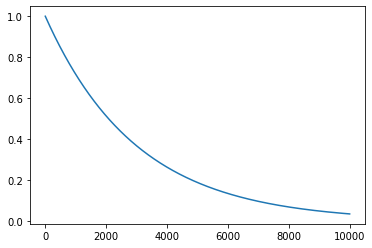

In [43]:
x = list(range(10000))
# print(x)
k = 3000
y = [float(np.exp(-i/k)) for i in x]
# print(y)
plt.plot(x,y)

In [ ]:
plt.plot(x_axis,epsilon_list,'r')
plt.plot(x_axis,rewards_list,'g')
plt.plot(x_axis,path_length_list,'b')

In [ ]:
plt.show()

In [14]:
problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_3.vrp')
problem.wfunc(1,10)

11

In [33]:
class keka:
    def test(self,i):
        return i[1]
    a = [(1,3),(2,1),(3,2)]
    def uppu(self):
        self.a.sort(reverse=True,key=self.test)
        return self.a
    
k = keka()
print(k.uppu())

[(1, 3), (3, 2), (2, 1)]
